###### TODO:

1.  Take MBDNL as the reference to quantify the error ( user relative error )

2.  Check for Cu and Alkaline Earth metals

3.  Find formal charges by beggar's analysis in MBDNL optimised geometry

4.  Consider absolute electronegetiy of each elements present also as a fetaure function ( for the mettalic things )

5.  Polarisibility 



In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [217]:
comp = "CsH"
d3 = pd.read_csv(f'd3/{comp}.csv')
mbd = pd.read_csv(f'mbd/{comp}.csv')


In [218]:
mbd.head()

,cell_length,energy,E-dispersion
0,6.49869,-18.203213,-0.15729
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


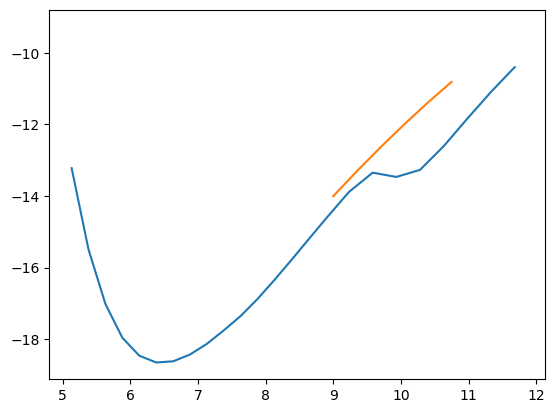

In [219]:
# plt.plot(cuppor['cell_length'], cuppor['energy'], 'o')
plt.plot(d3['cell_length'], d3['energy'])

# plt.plot(copper_mbd['cell_length'], copper_mbd['energy'], 'o')
plt.plot(mbd['cell_length'], mbd['energy'])

plt.show()

In [220]:


def compare_energy_data(d3, mbd, offset_ref_index=(6, 0), isPlot=False):
    """
    Compare energy differences between two datasets with different cell lengths.

    Parameters:
        d3 (pd.DataFrame): First dataset with 'cell_length' and 'energy' columns.
        mbd (pd.DataFrame): Second dataset with 'cell_length' and 'energy' columns.
        offset_ref_index (tuple): A tuple specifying indices for offset calculation 
                                  (index for data1['energy'], index for data2['energy']).
    
    Returns:
        pd.DataFrame: DataFrame with energy differences and interpolated values.
    """
    # Calculate offset based on specified reference indices
    offset = mbd['energy'][offset_ref_index[1]] - d3['energy'][offset_ref_index[0]]
    
    # Interpolate data2's energy values at data1's cell_length points
    mbd_interp = np.interp(d3['cell_length'], mbd['cell_length'], mbd['energy'])
    
    # Calculate the difference in energy values

    # handle the null values in mbd_interp
    mbd_interp = np.nan_to_num(mbd_interp)
    for i in range(len(mbd_interp)):
        if mbd_interp[i] == 0:
            mbd_interp[i] = d3['energy'][i]

    offset = np.nan_to_num(offset)
            
    # print(f"offset is {offset}")
    
    energy_diff =  mbd_interp - d3['energy']
    
    
    # Add the difference to the DataFrame for visualization
    result = d3.copy()
    result['energy_diff'] = energy_diff
    result['mbd_interp'] = mbd_interp
    # Plot the original data
    
    if isPlot:
        plt.figure(figsize=(10, 6))
        plt.plot(d3['cell_length'], d3['energy'], label='Data 1 (Reference)', marker='o')
        plt.plot(mbd['cell_length'], mbd['energy'], label='Data 2 (Original)', marker='x')
        plt.plot(d3['cell_length'], energy_diff, label='Energy Difference', linestyle='--')

        # Add labels and legend
        plt.xlabel('Cell Length')
        plt.ylabel('Energy')
        plt.title('Comparison of Energy vs Cell Length')
        plt.legend()
        plt.grid()

        # Show the plot
        plt.show()

    print(max(result['energy_diff'][5:]) , abs(mbd['energy'][offset_ref_index[1]]))
    ans = max(result['energy_diff'])/ abs(mbd['energy'][offset_ref_index[1]])

    return ans*100


In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def optimize_polynomial_degree(data1, energy_diff, max_degree=10):
    """
    Optimize the polynomial degree by using cross-validation and selecting the best degree based on MSE.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (best_degree, best_mse) - The optimal polynomial degree and the corresponding MSE.
    """
    best_degree = None
    best_mse = float('inf')  # Start with an infinitely large MSE to minimize it
    
    # Prepare the data
    X = data1['cell_length'].values.reshape(-1, 1)
    y = energy_diff.values

    # Remove rows where y has NaN values
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    print(y)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    for degree in range(1, max_degree + 1):
        # Generate polynomial features for the current degree
        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_val_poly = poly_features.transform(X_val)
        
        # Fit the model
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Make predictions on the validation set
        y_pred = model.predict(X_val_poly)
        
        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(y_val, y_pred)
        
        # If this MSE is better, update the best degree and MSE
        if mse < best_mse:
            best_mse = mse
            best_degree = degree


    
    print(f"Optimal Polynomial Degree: {best_degree} with MSE: {best_mse:.4f}")
    return best_degree, best_mse

def find_polynomial_maximum_with_optimal_degree(data1, energy_diff, max_degree=10):
    """
    Fit a polynomial regression to the data with an optimized degree and find the maximum value of the polynomial curve.

    Parameters:
        data1 (pd.DataFrame): The dataset with 'cell_length' column.
        energy_diff (pd.Series): The energy difference data.
        max_degree (int): The maximum degree to consider for polynomial fitting. Default is 10.
    
    Returns:
        tuple: (max_cell_length, max_energy_diff) - The cell length and energy difference at the maximum.
    """
    # Remove rows with NaN values from energy_diff and align with data1
    valid_indices = energy_diff.dropna().index
    data1 = data1.loc[valid_indices].reset_index(drop=True)
    energy_diff = energy_diff.dropna().reset_index(drop=True)

    # Find the optimal polynomial degree
    # optimal_degree, _ = optimize_polynomial_degree(data1, energy_diff, max_degree=max_degree)
    
    optimal_degree = max_degree

    # Prepare the polynomial features for the optimal degree
    poly_features = PolynomialFeatures(degree=optimal_degree)
    X_poly = poly_features.fit_transform(data1['cell_length'].values.reshape(-1, 1))
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_poly, energy_diff)
    
    # Generate finer cell length values for extrapolation
    fine_cell_lengths = np.linspace(min(data1['cell_length']), max(data1['cell_length']), 500)
    fine_cell_lengths_poly = poly_features.transform(fine_cell_lengths.reshape(-1, 1))
    energy_diff_fine = model.predict(fine_cell_lengths_poly)
    
    # Calculate the first derivative (slope) of the fitted polynomial
    poly_coeffs = model.coef_[1:]  # Skip the first coefficient as it corresponds to the constant term
    first_derivative_coeffs = np.polyder(poly_coeffs)
    
    # Find the root of the first derivative (where slope = 0)
    critical_points = np.roots(first_derivative_coeffs)
    
    # We are interested in real roots that fall within the domain of the data
    critical_points_real = [point.real for point in critical_points if point.imag == 0 and min(data1['cell_length']) <= point.real <= max(data1['cell_length'])]
    
    # Evaluate the second derivative to check for maxima
    second_derivative_coeffs = np.polyder(first_derivative_coeffs)
    
    max_cell_length = None
    max_energy_diff = None
    
    for point in critical_points_real:
        # Evaluate the second derivative at each critical point to check for maximum (second derivative < 0)
        second_derivative_value = np.polyval(second_derivative_coeffs, point)
        if second_derivative_value < 0:  # This means it's a maximum
            max_cell_length = point
            max_energy_diff = np.polyval(poly_coeffs, point)
            break
    
    # Plot the original data and polynomial fit
    plt.figure(figsize=(10, 6))
    plt.plot(data1['cell_length'], energy_diff, label='Energy Difference', linestyle='--', marker='o')
    plt.plot(fine_cell_lengths, energy_diff_fine, label=f'Polynomial Fit (Degree {optimal_degree})', linestyle='--')
    # plt.scatter(max_cell_length, max_energy_diff, color='red', label=f'Maximum at {max_cell_length:.3f}')
    
    # Add labels and legend
    plt.xlabel('Cell Length')
    plt.ylabel('Energy Difference')
    plt.title(f'Energy Difference and Polynomial Regression (Optimal Degree {optimal_degree})')
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

    return max_cell_length, max_energy_diff

# Example usage:
# Assuming `data1` is your dataframe with 'cell_length' and `energy_diff` is your computed energy difference
# max_cell, max_energy = find_polynomial_maximum_with_optimal_degree(data1, energy_diff)


In [222]:

ans = compare_energy_data(d3,mbd,offset_ref_index=(6,0))
ans

# first one is MBD



1.6773488922509596 18.203213


np.float64(9.214575977608785)

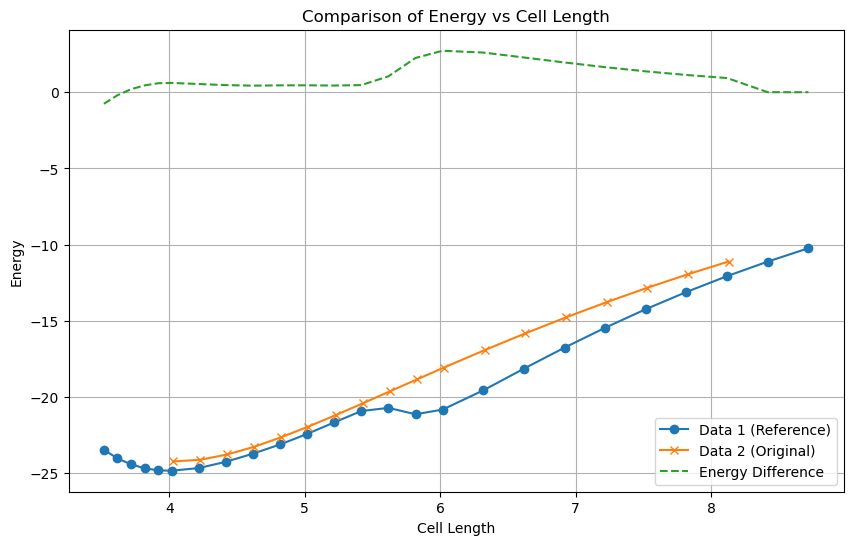

2.7202302471491997 24.219764


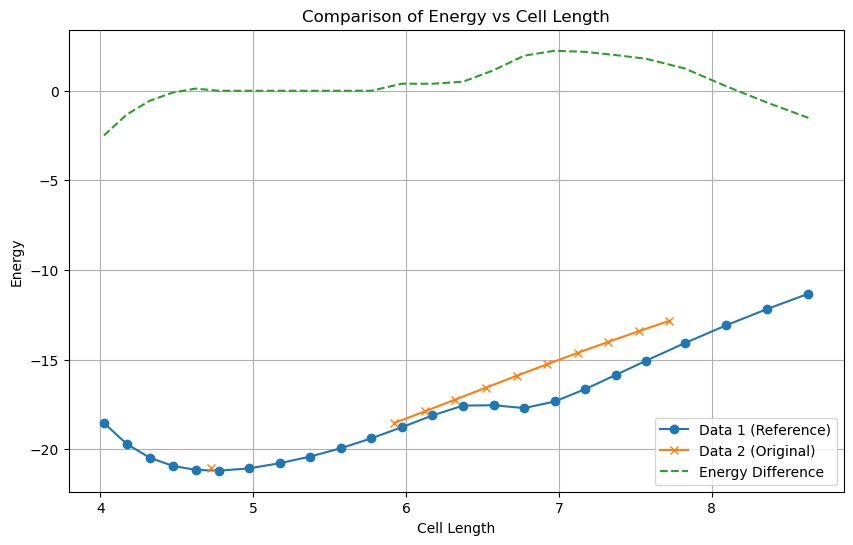

2.2347865473104793 21.036822


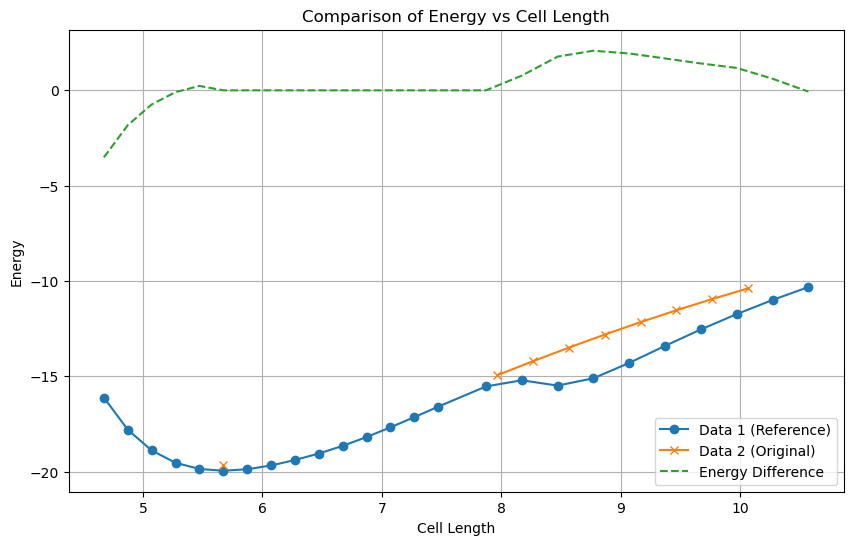

2.0763972772251567 19.624813


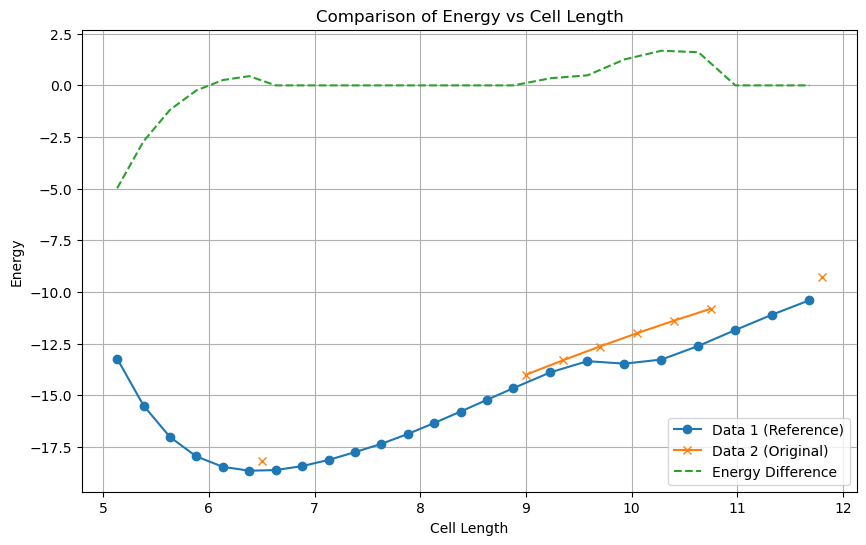

1.6773488922509596 18.203213


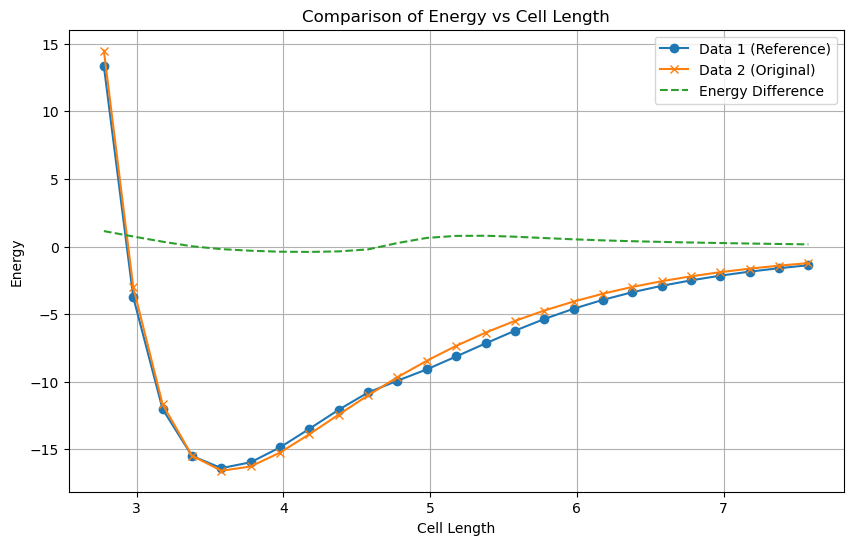

0.7965641999999997 16.267227


[np.float64(11.231448197221077),
 np.float64(10.623213655135167),
 np.float64(10.580469109311547),
 np.float64(9.214575977608785),
 np.float64(7.0130821928039735)]

In [223]:

comps = ["LiH", "NaH", "KH", "CsH","Cu"]

res = []

for comp in comps:
    d3 = pd.read_csv(f'd3/{comp}.csv')
    mbd = pd.read_csv(f'mbd/{comp}.csv')
    if comp == "Cu":
        ans = compare_energy_data(d3,mbd,offset_ref_index=(5,5), isPlot=True)
    else:
        ans = compare_energy_data(d3,mbd,offset_ref_index=(6,0), isPlot=True)
    res.append(ans)
    # print(f"Max difference for {comp}: {ans}")

res

In [224]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    # Convert to float to handle integer to negative power issue
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
            for name in subset_names:
                if name.endswith("^(-1)") and name[:-5] in subset_names:
                    invalid = True
                    break
                elif name in param_names and f"{name}^(-1)" in subset_names:
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [243]:

# List of molecules

# Data for each property
# data = {
#     "Mol": molecules,  # Molecule
#     "Cat_EN": [0.98, 0.93, 0.82, 0.79, 1.90, 1.90, 0.98, 1.90, 1.31, 0.98, 0.93],  # Cation electronegativity
#     "Ani_EN": [2.20, 2.20, 2.20, 2.20, 2.20, 1.90, 3.98, 2.66, np.nan, np.nan, np.nan],  # Anion electronegativity
#     "Pol_C": [164.1, 162.7, 289.7, 400.9, 46.5, 46.5, 164.1, 46.5, 71.2, 164.1, 162.7],  # Cation polarizability
#     "Pol_A": [4.51, 4.51, 4.51, 4.51, 4.51, 46.5, 0.56, 6.35, np.nan, np.nan, np.nan],  # Anion polarizability
#     "Rad_C": [152.0, 186.0, 227.0, 343.0, 260.0, 128.0, 152.0, 128.0, 160.0, 152.0, 186.0],  # Cation radius (pm)
#     "Rad_A": [53.0, 53.0, 53.0, 53.0, 53.0, np.nan, 147.0, 206.0, np.nan, np.nan, np.nan],  # Anion radius (pm)
#     "CN": [6.0, 6.0, 6.0, 6.0, 6.0, np.nan, 6.0, 6.0, 6.0, np.nan, np.nan],  # Coordination number
#     "Ion_C": [520.2, 495.8, 418.8, 376.6, 745.5, 745.5, 520.2, 745.5, 737.7, 520.2, 495.8],  # Cation ionization energy (kJ/mol)
#     "Ion_A": [1312.0, 1312.0, 1312.0, 1312.0, 1312.0, np.nan, 1681.0, 1007.0, np.nan, np.nan, np.nan],  # Anion ionization energy (kJ/mol)
#     "EA_A": [72.8, 72.8, 72.8, 72.8, 72.8, np.nan, 328.0, 295.0, np.nan, np.nan, np.nan],  # Anion electron affinity (kJ/mol)
#     "EA_C": [59.6, 52.8, 48.4, 45.5, 119.2, 119.2, 59.6, 119.2, 0.0, 59.6, 52.8],  # Cation electron affinity (kJ/mol)
# }

# Create a DataFrame
df = pd.read_csv("molecule_properties_shortest.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules[:-3]
molecules


array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'Cu', 'LiF', 'CuI'], dtype=object)

#### find the error in molecules ( Molecules )

Processing LiH...


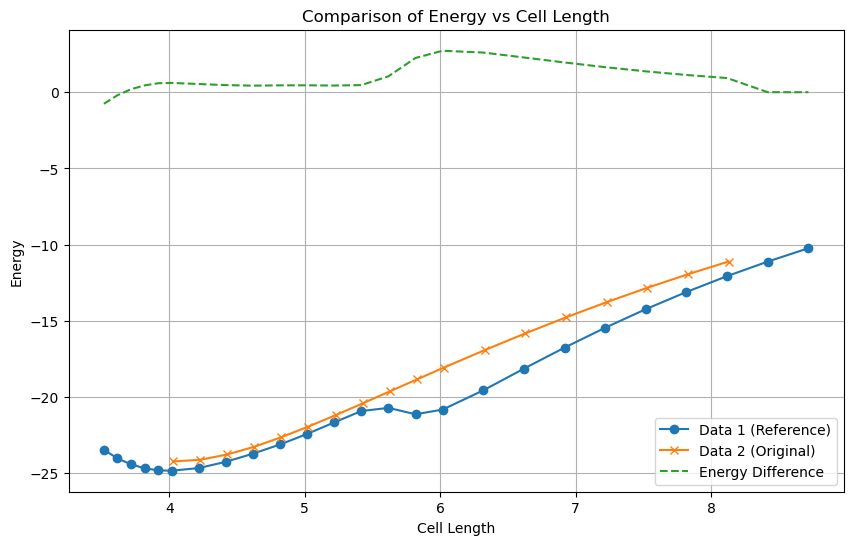

2.7202302471491997 24.219764
Max difference for LiH: 11.231448197221077
Processing NaH...


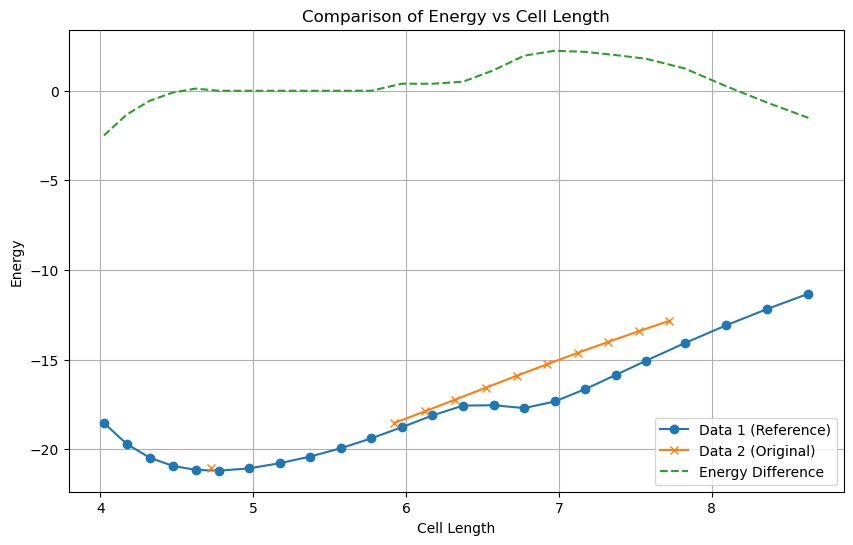

2.2347865473104793 21.036822
Max difference for NaH: 10.623213655135167
Processing KH...


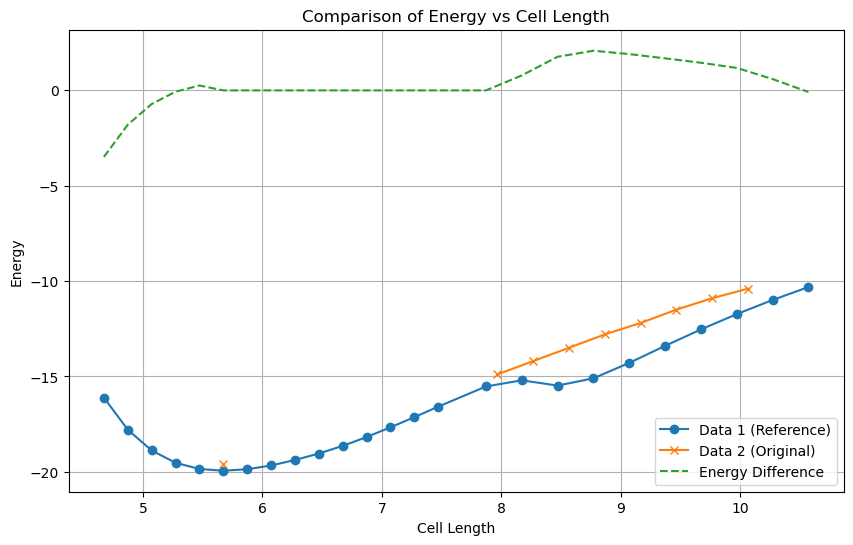

2.079470630699994 19.6
Max difference for KH: 10.609544034183644
Processing RbH...


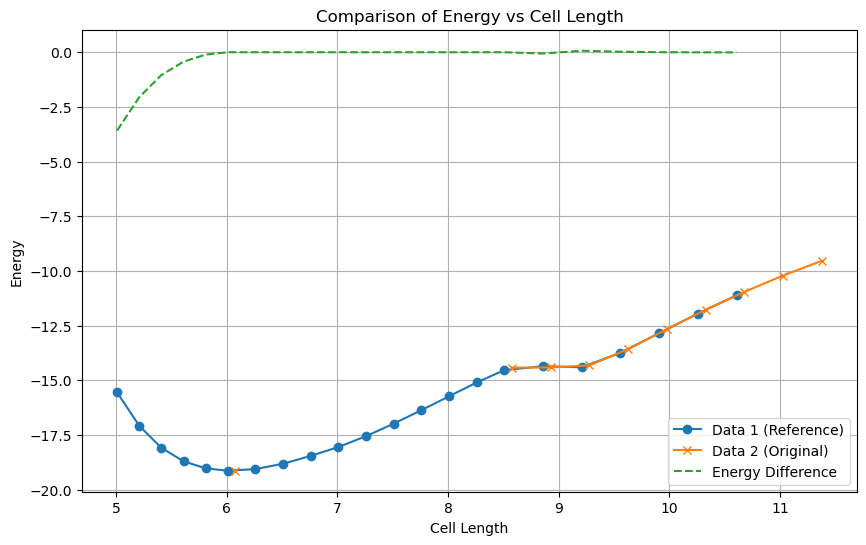

0.0689390541012802 19.132331
Max difference for RbH: 0.3603275215198828
Processing CsH...


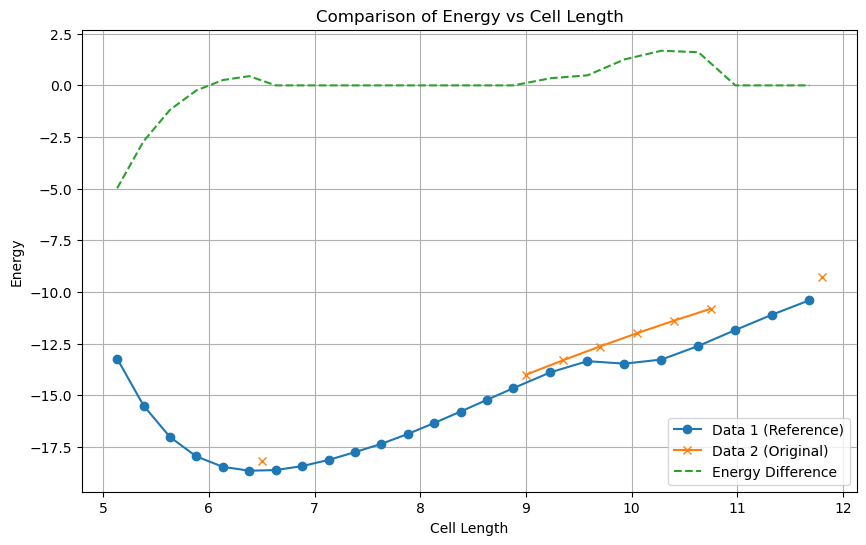

1.6773488922509596 18.203213
Max difference for CsH: 9.214575977608785
Processing Cu...


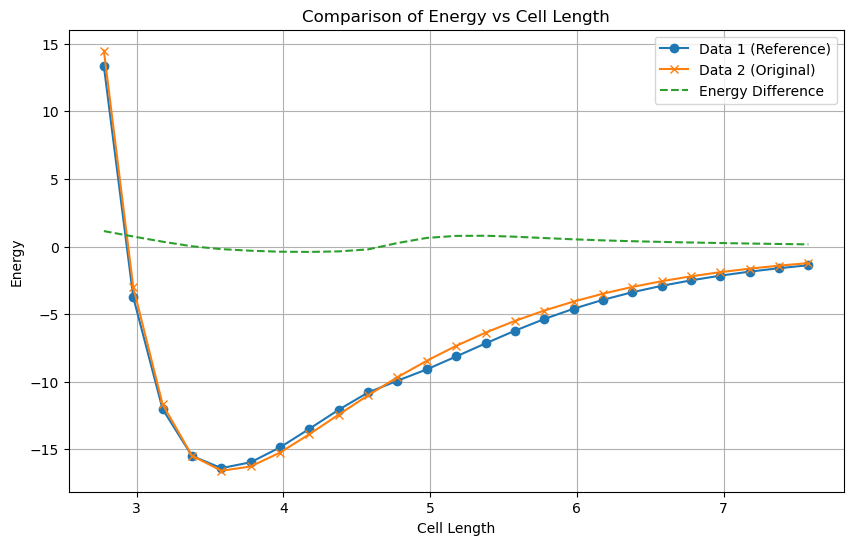

0.7965641999999997 16.267227
Max difference for Cu: 7.0130821928039735
Processing LiF...


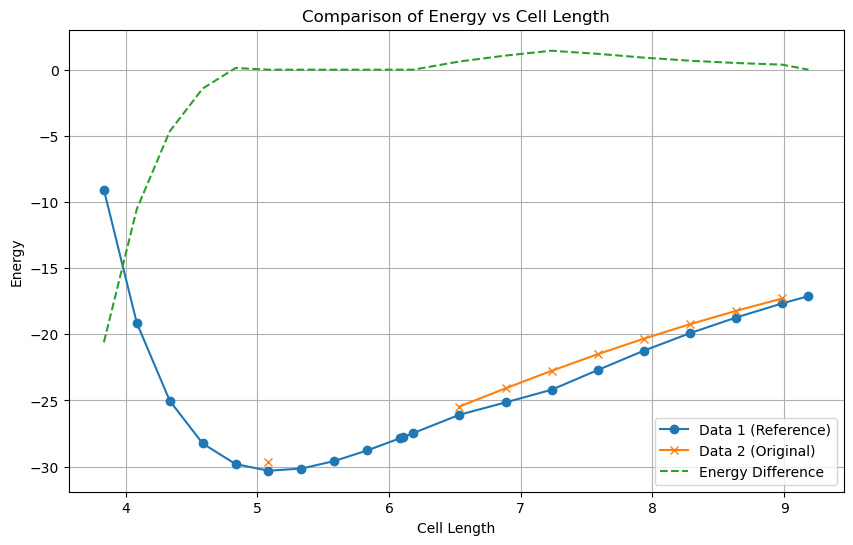

1.4321739999999998 29.686685
Max difference for LiF: 4.824297492293262
Processing CuI...


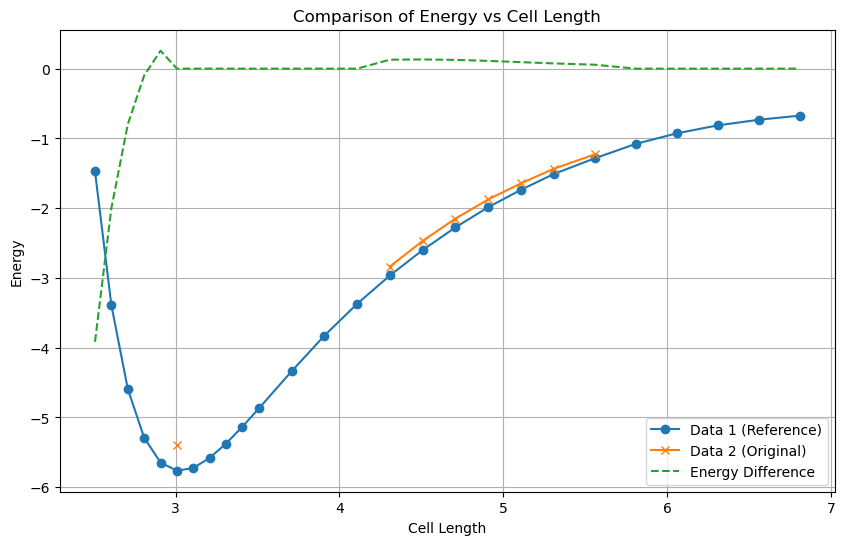

0.13152760000000008 5.3896658
Max difference for CuI: 4.766122975565567


[np.float64(11.231448197221077),
 np.float64(10.623213655135167),
 np.float64(10.609544034183644),
 np.float64(0.3603275215198828),
 np.float64(9.214575977608785),
 np.float64(7.0130821928039735),
 np.float64(4.824297492293262),
 np.float64(4.766122975565567)]

In [244]:
res = []

for comp in molecules:
    print(f"Processing {comp}...")
    d3 = pd.read_csv(f'd3/{comp}.csv')
    mbd = pd.read_csv(f'mbd/{comp}.csv')
    if comp == "Cu":
        ans = compare_energy_data(d3,mbd,offset_ref_index=(5,5), isPlot=True)
    else:
        ans = compare_energy_data(d3,mbd,offset_ref_index=(6,0), isPlot=True)
    res.append(ans)
    print(f"Max difference for {comp}: {ans}")
    # print(f"Max difference for {comp}: {ans}")

res

In [229]:
df.iloc[:9,0:9]

,Mol,Cat_EN,Ani_EN,Pol_C,Pol_A,Rad_C,Rad_A,CN,Ion_C
0,LiH,0.98,2.20,164.1,4.51,152,53,6,5.392
1,NaH,0.93,2.20,162.7,4.51,186,53,6,5.139
2,KH,0.82,2.20,289.7,4.51,227,53,6,4.341
3,RbH,0.79,2.20,400.9,4.51,343,53,6,4.177
4,CsH,1.90,2.20,46.5,4.51,260,53,6,3.849
5,Cu,1.90,1.90,46.5,46.50,128,128,8,7.726
6,LiF,0.98,3.98,164.1,0.56,152,147,6,5.392
7,CuI,1.90,2.66,46.5,6.35,128,206,6,7.726
8,Mg,1.31,1.31,71.2,71.20,160,160,8,7.646


In [231]:

start = 0
end = 5
# parameters = [a[start:end],b[start:end],c[start:end],e[start:end],g[start:end],h[start:end],i[start:end],j[start:end]]
# # parameters = [h[start:end],i[start:end],j[start:end]]
# # parameters = [e[start:end],f[start:end],g[start:end]]
# param_names = ['a','b','c','e','g','h','i','j']	
# param_names = ['h','i','j']
# param_names = ['e','f','g']
param_names = list(df.iloc[:10,1:10].columns)

# # Define mathematical operators
operators = ['*', '/',]



# # Generate and evaluate all expressions
print(df.iloc[:,1:].shape)
# print(len(param_names[1:]))
all_expressions = generate_combinations_df(df.iloc[:,1:9],param_names[:8])



df = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

df.shape

(11, 11)


C:\Users\user\AppData\Local\Temp\ipykernel_15260\190203720.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


(6560, 2)

In [232]:
df.head()

,Expression,Value
0,Cat_EN,0 0.98 1 0.93 2 0.82 3 0.79 4 ...
1,Ani_EN,0 2.20 1 2.20 2 2.20 3 2.20 4 ...
2,Pol_C,0 164.1 1 162.7 2 289.7 3 400....
3,Pol_A,0 4.51 1 4.51 2 4.51 3 ...
4,Rad_C,0 152 1 186 2 227 3 343 4 ...


In [200]:

values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
# values['res'] = res[:8]

In [201]:
values.head()

correlation = values.corr()

correlation.shape

(19682, 19682)

In [203]:
results=correlation[''].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

KeyError: 'res'

In [204]:
import pickle

# Create a variable to save
my_variable = [1, 2, 3, 4, 5]

# Save the variable to a pickle file
with open('corel.pkl', 'wb') as f:
    pickle.dump(correlation, f)

In [202]:
# Plot each variable against `res`
plt.figure(figsize=(12, 8))

for i, var in enumerate(top_vars, 1):
    plt.subplot(4, 5, i)  # 4 rows, 5 columns for subplots
    
    # Plot the line
    plt.plot(values[var], values['res'], linestyle='-', color='blue', alpha=0.7)
    
    # Scatter plot with markers
    plt.scatter(values[var], values['res'], marker='o', color='red', alpha=0.8)
    
    # Annotate each point with its index
    for idx in range(len(values)):
        plt.text(values[var].iloc[idx], values['res'].iloc[idx], str(idx), fontsize=6, color='black', alpha=0.7)
    
    # Titles and labels
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('res')

plt.tight_layout()
plt.show()


NameError: name 'top_vars' is not defined

<Figure size 1200x800 with 0 Axes>

### Feature functions to be used

1. Electronegetivities of each atom involded

2. sum of electronegetivities 

3. Difference of electronegetivities

4. polarisibility

6. Redox potentials 

7. Atomic raiis , sum of atomic raii

8. Formal Charges ( dont know how to take that )

9. Also should have test data 

10. coordination number

### TODO:
1. Check the Y values more properly and accurately 

2. Add more compunds 

3. Try for more feature fucntions 


In [ ]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(x, -1))
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]
            subset = combined_params_df[subset_names]

            # Check if both a parameter and its inverse are in the subset
            invalid = False
            for name in subset_names:
                if name.endswith("^(-1)") and name[:-5] in subset_names:
                    invalid = True
                    break
                elif name in param_names and f"{name}^(-1)" in subset_names:
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

# Example DataFrame for demonstration
molecules = ["LiH", "NaH", "KH", "RbH", "CsH"]
data = {
    "asdfs": [0.98, 0.93, 0.82, 0.79, 1.90],
    "b": [2.20, 2.20, 2.20, 2.20, 2.20],
    "c": [164.1, 162.7, 289.7, 400.9, 46.5],
    "e": [4.51, 4.51, 4.51, 4.51, 4.51],
    "g": [152.0, 186.0, 227.0, 343.0, 260.0],
    "h": [53.0, 53.0, 53.0, 53.0, 53.0],
    "i": [520.2, 495.8, 418.8, 376.6, 745.5],
    "j": [1312.0, 1312.0, 1312.0, 1312.0, 1312.0],
}
params_df = pd.DataFrame(data)
param_names = list(params_df.columns)

# Generate combinations
all_expressions = generate_combinations_df(params_df, param_names)

# Create a DataFrame for the results
results_df = pd.DataFrame(
    [(expr, val.tolist()) for expr, val in all_expressions],
    columns=["Expression", "Value"]
)




C:\Users\user\AppData\Local\Temp\ipykernel_15260\789170131.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(x, -1))


In [36]:
results_df.shape

(6560, 2)

In [54]:
params_df

,asdfs,b,c,e,g,h,i,j
0,0.98,2.2,164.1,4.51,152.0,53.0,520.2,1312.0
1,0.93,2.2,162.7,4.51,186.0,53.0,495.8,1312.0
2,0.82,2.2,289.7,4.51,227.0,53.0,418.8,1312.0
3,0.79,2.2,400.9,4.51,343.0,53.0,376.6,1312.0
4,1.90,2.2,46.5,4.51,260.0,53.0,745.5,1312.0
